<a href="https://colab.research.google.com/github/RidmieWee/DS_Project/blob/main/3.%20Implementation/drowsiness_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [2]:
# Mount into the drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploratary Data Analysis

In [3]:
# Load one image
img = cv2.imread('../content/drive/MyDrive/Research/data/Opened_Eyes/s0012_04624_0_0_1_2_1_03.png', cv2.IMREAD_GRAYSCALE)

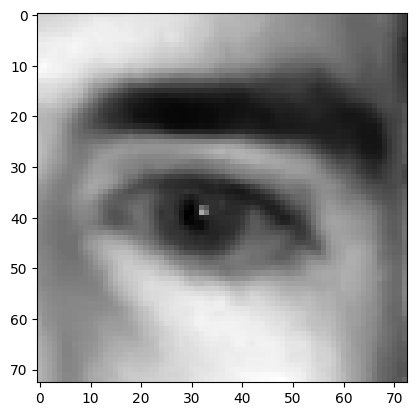

In [4]:
# Display that image
plt.imshow(img, cmap="gray")

In [5]:
# Define data folder and classes
images = '../content/drive/MyDrive/Research/data'
categories = ['Closed_Eyes', 'Opened_Eyes']

In [6]:
# Define a array for stre images
data = []

# Define a function to extract data from folder
def extract_data():
    # Iterate over each folder in directory
    for category in categories:
        # Defie the path to directory
        path = os.path.join(images, category)
        # Extract the index
        class_num = categories.index(category)
        # Iterate over each imane
        for img in os.listdir(path):
            try:
                # Read image
                img_array = cv2.imread(os.path.join(path, img))
                # Add image and labelinto new array
                data.append([img_array, category])
            # Check for any errors to ignore
            except Exception as e:
                pass

In [7]:
# Call function to extract data
extract_data()

In [8]:
# Ensure the data length
print(len(data))

10000


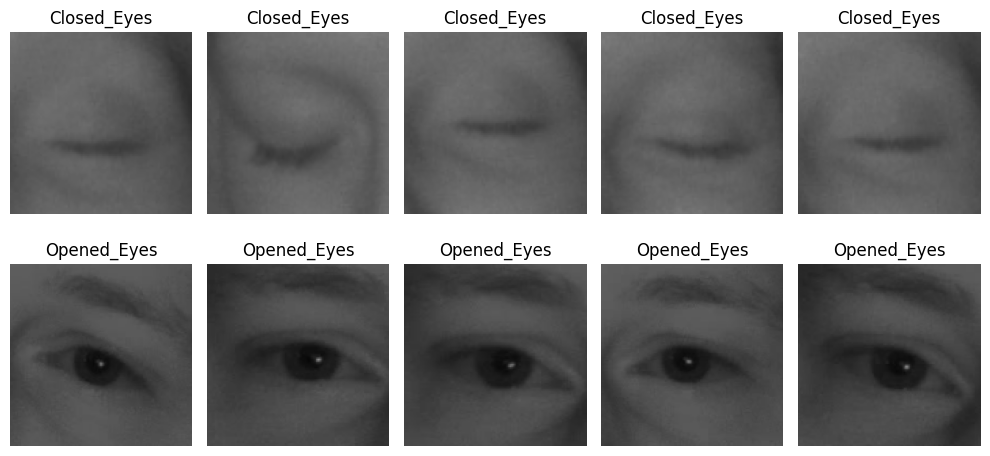

In [9]:
# Explore extract images

# Define the number of rows and columns
rows = 2
columns = 5

# Define size for the figure
plt.figure(figsize=(10, 5))

# Iterate over each class
for class_name in categories:
    # Filter images of each class
    class_images = [img_data for img_data in data if img_data[1] == class_name]
    # Plot images of each class
    for i in range(min(len(class_images), 5)):
        plt.subplot(rows, columns, categories.index(class_name) * 5 + i + 1)
        plt.imshow(class_images[i][0])
        plt.title(class_name)
        plt.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
# Calculate image statistics

# Define a function to extract image statistics
def calculate_image_statistics(data):
    # Define dictionary to store statistics for each category
    statistics = {'Closed_Eyes': [], 'Opened_Eyes': []}
    # Iterate over each image-category pair
    for image, category in data:
        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Add mean pixel intensity
        statistics[category].append(np.mean(grayscale_image))
    # Return new dictionary
    return statistics

# Call function to calculate image statistics
image_statistics = calculate_image_statistics(data)

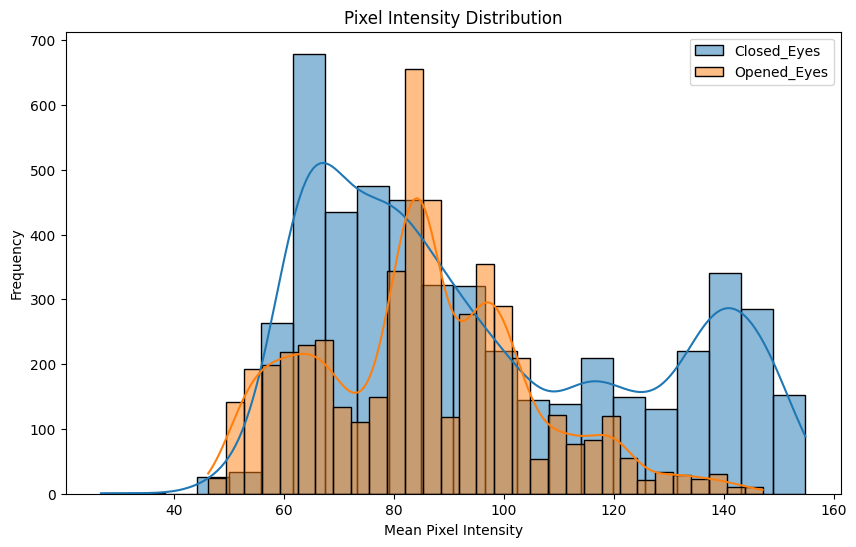

In [11]:
# Plot histograms of pixel intensity distributions
# Define a figure
plt.figure(figsize=(10, 6))

# Iterte over each category
for category in categories:
    # Plot data points as a histogram
    sns.histplot(image_statistics[category], kde=True, label=category, alpha=0.5)

# Define labels for axies and title
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
# Add legend
plt.legend()

# Plot the graph
plt.show()

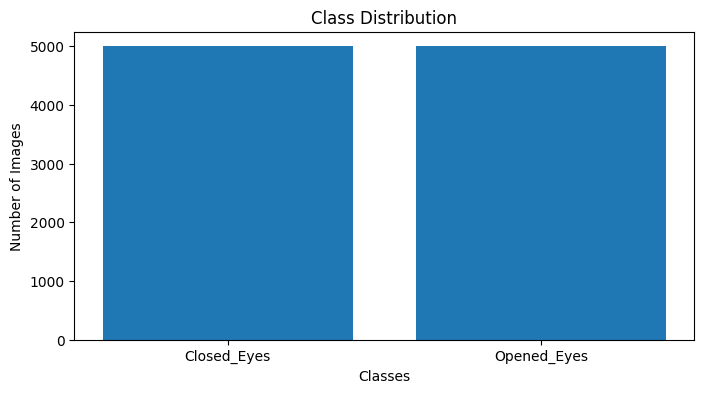

In [12]:
# Identify class imbalance

# Define a figure
plt.figure(figsize=(8, 4))

# Calculate the total images
image_count = {category: len([img for img,
                              cat in data if cat == category])
                              for category in categories}

# Plot the count of each category
plt.bar(image_count.keys(), image_count.values())

# Define axis labels and titles
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')

# Show the plot
plt.show()

In [13]:
# Check the shape of each image

# Iterate over each image
for image, category in data:

    # Check the shape
    image_shape = image.shape

    # Print the shape
    print(f"Image shape: {image_shape}, Category: {category}")

Streaming output truncated to the last 5000 lines.
Image shape: (134, 134, 3), Category: Opened_Eyes
Image shape: (117, 117, 3), Category: Opened_Eyes
Image shape: (116, 116, 3), Category: Opened_Eyes
Image shape: (134, 134, 3), Category: Opened_Eyes
Image shape: (116, 116, 3), Category: Opened_Eyes
Image shape: (137, 137, 3), Category: Opened_Eyes
Image shape: (120, 120, 3), Category: Opened_Eyes
Image shape: (123, 123, 3), Category: Opened_Eyes
Image shape: (137, 137, 3), Category: Opened_Eyes
Image shape: (75, 75, 3), Category: Opened_Eyes
Image shape: (136, 136, 3), Category: Opened_Eyes
Image shape: (132, 132, 3), Category: Opened_Eyes
Image shape: (136, 136, 3), Category: Opened_Eyes
Image shape: (112, 112, 3), Category: Opened_Eyes
Image shape: (139, 139, 3), Category: Opened_Eyes
Image shape: (137, 137, 3), Category: Opened_Eyes
Image shape: (131, 131, 3), Category: Opened_Eyes
Image shape: (118, 118, 3), Category: Opened_Eyes
Image shape: (139, 139, 3), Category: Opened_Eyes
I

In [14]:
# Define the newsize
new_size = (64, 64)

# Iterate over each image
for i in range(len(data)):

    # Extract image and category
    image, category = data[i]

    # Resize the image
    resized_image = cv2.resize(image, new_size)

    # Add the image with new size
    data[i] = (resized_image, category)

In [15]:
# Extract one image
image1 = data[0][0]

# Check shape of the image
image_shape = image1.shape

# Print the shape
print(image_shape)

(64, 64, 3)


In [16]:
# Iterate over each image
for i in range(len(data)):
    # Extract the images and label
    img_array, category = data[i]

    # Convert it into grayscale
    grayscale_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Update the data list with the grayscale image
    data[i] = [grayscale_img, category]


In [17]:
# Extract one image
image1 = data[0][0]

# Check shape of the image
image_shape = image1.shape

# Print the shape
print(image_shape)

(64, 64)


# Data Preprocessing

In [18]:
# Construct random data

# Shuffling the data
random.shuffle(data)

In [19]:
# Define lists data images and labels
X = []
y = []

# Iterate over each image
for features, label in data:

    # Add images into the list
    X.append(features)
    # Add labels into the list
    y.append(label)

# Convert into a numpy array
X = np.array(X)
Y = np.array(y)

In [20]:
# Explore the shape of image list
X.shape

(10000, 64, 64)

In [21]:
# Expanding 2D dimension into 3D
X = np.expand_dims(X,-1)

In [22]:
# Splitting data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [23]:
# Explore shape
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6700, 64, 64, 1) (6700,) (3300, 64, 64, 1) (3300,)


In [24]:
# Normalizing the images using min-max scaling

# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Reduce pixel values
x_train /= 255
x_test /= 255

In [25]:
# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [26]:
# Define data augmentation
train_generator = ImageDataGenerator(
    # Randomly rotate image
    rotation_range=20,
    # Defime zoom range
    zoom_range=0.15,
    # Randomly shift images horizontally
    width_shift_range=0.2,
    # Randomly shift images vertically
    height_shift_range=0.2,
    # Define random shear
    shear_range=0.15,
    # Define flip image
    horizontal_flip=True,
    # Define mode for filling points
    fill_mode="nearest")

In [27]:
# Define data augmentation
train_generator_90 = ImageDataGenerator(
    # Rotate image 90 degrees
    rotation_range=90,
    # Defime zoom range
    zoom_range=0.15,
    # Randomly shift images horizontally
    width_shift_range=0.2,
    # Randomly shift images vertically
    height_shift_range=0.2,
    # Define random shear
    shear_range=0.15,
    # Define flip image
    horizontal_flip=True,
    # Define mode for filling points
    fill_mode="nearest")

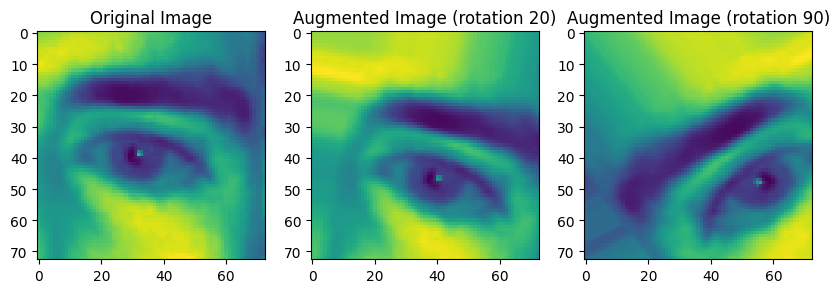

In [28]:
# Display exampleoutput after data augmentation

# Convert sample image tp numpy array
original_img_array = img_to_array(img)

# Apply augmentation to sample image
augmented_img_array = train_generator.random_transform(original_img_array)
augmented_img_array1 = train_generator_90.random_transform(original_img_array)

# Convert augmented image back to PIL format
augmented_img = array_to_img(augmented_img_array)
augmented_img1 = array_to_img(augmented_img_array1)

# Plot the original and augmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(augmented_img)
plt.title('Augmented Image (rotation 20)')

plt.subplot(1, 3, 3)
plt.imshow(augmented_img1)
plt.title('Augmented Image (rotation 90)')

plt.show()


# Model definition, training and evaluation

## 1. ModelA - Model with Conv2D(32, 64) + Flatten + Dense(128,64) + Output(Dense 1)

In [29]:
# Initialize the model
modelA = Sequential()

# Define convolutional layers
modelA.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(64, 64, 1)))

modelA.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

# Flatten the output of the convolutional layers
modelA.add(Flatten())

# Define dense layers
modelA.add(Dense(units=128, activation='relu'))
modelA.add(Dense(units=64, activation='relu'))

# Define output layer
modelA.add(Dense(units=1, activation='sigmoid'))

In [96]:
# Print model summary
modelA.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 flatten_3 (Flatten)         (None, 230400)            0         
                                                                 
 dense_9 (Dense)             (None, 128)               29491328  
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 29518465 (112.60 MB)
Trainable params: 2

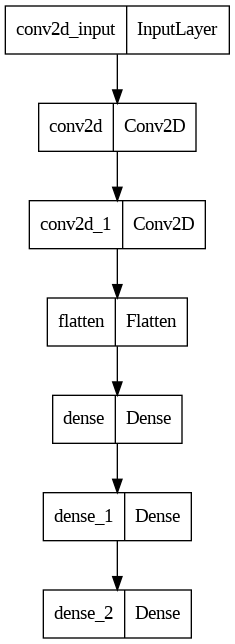

In [46]:
# Plot model
plot_model(modelA)

In [30]:
# Compile the model
modelA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# Define the path to save the model
path = '../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1'

# Ensure the directory exists
os.makedirs(path, exist_ok=True)

### 30 epochs with 32 batch size

In [49]:
# Define the path to save the model
model_checkpoint_path = os.path.join(path, 'bestmodel_modelA.h5')

In [50]:
callback_base = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [51]:
# Train the model
history_modelA = modelA.fit(x_train, y_train_encoded, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_base)

Epoch 1/30
168/168 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9231
Epoch 1: val_loss improved from inf to 0.08553, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/168 [==============================] - 36s 209ms/step - loss: 0.2114 - accuracy: 0.9231 - val_loss: 0.0855 - val_accuracy: 0.9746
Epoch 2/30
168/168 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9739
Epoch 2: val_loss improved from 0.08553 to 0.05288, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA.h5
168/168 [==============================] - 38s 228ms/step - loss: 0.0774 - accuracy: 0.9739 - val_loss: 0.0529 - val_accuracy: 0.9866
Epoch 3/30
168/168 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9882
Epoch 3: val_loss improved from 0.05288 to 0.01851, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA.h5
168/168 [==============================] - 37s 222ms/step - loss: 0.0336 - accuracy: 0.9882 - val_loss: 0.0185 - val_accuracy: 0.9948
Epoch 4/30
168/168 [==============================] - ETA: 0s - loss: 0.0239 -

In [52]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA = modelA.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA[0])
print('Test accuracy:', test_loss_accuracy_modelA[1])

104/104 [==============================] - 4s 34ms/step - loss: 0.0142 - accuracy: 0.9979
Test loss: 0.01416702289134264
Test accuracy: 0.9978787899017334


In [53]:
# Set plot style
plt.style.use('bmh')

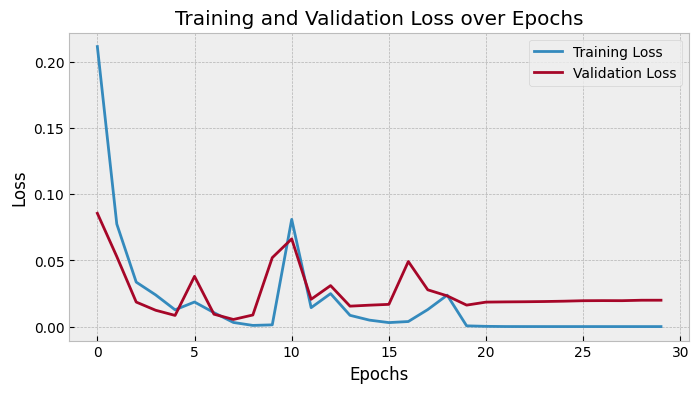

In [54]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA.history['loss'], label='Training Loss')
plt.plot(history_modelA.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()

# Plot the graph
plt.show()

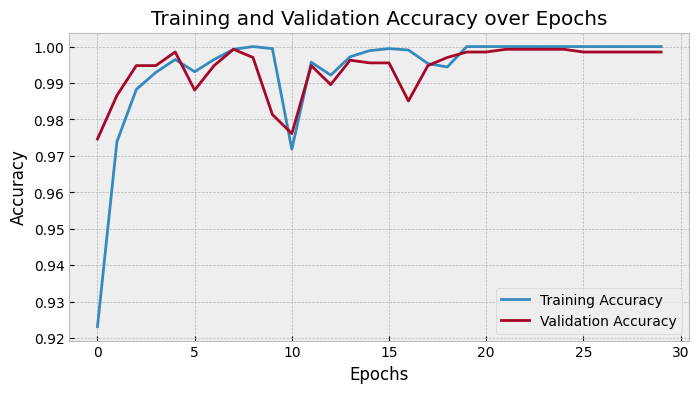

In [55]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [56]:
# Save the entire model
modelA.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/modelA.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step


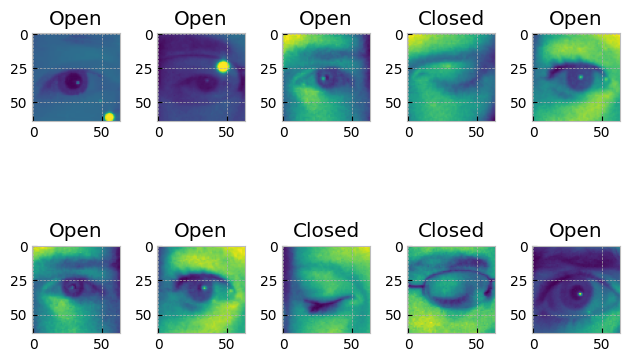

In [57]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = modelA.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 3s 32ms/step


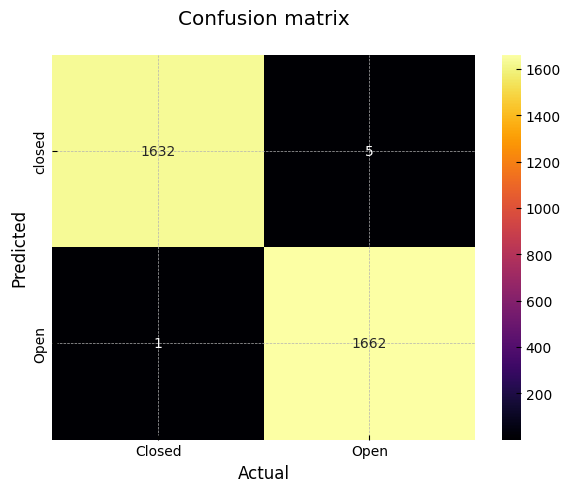

In [74]:
# Make predictions
preds2 = history_modelA.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

### 10 epochs with 32 batch size

In [64]:
# Define the path to save the model
model_checkpoint_path1 = os.path.join(path, 'bestmodel_modelA_1.h5')

In [65]:
callback_base_1 = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path1,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [66]:
# Train the model
history_modelA_1 = modelA.fit(x_train, y_train_encoded, validation_split=0.2, epochs=10, batch_size=32, callbacks=callback_base_1)

Epoch 1/10
168/168 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9177
Epoch 1: val_loss improved from inf to 0.04751, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA_1.h5
168/168 [==============================] - 39s 227ms/step - loss: 0.1863 - accuracy: 0.9177 - val_loss: 0.0475 - val_accuracy: 0.9881
Epoch 2/10
168/168 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9830
Epoch 2: val_loss did not improve from 0.04751
168/168 [==============================] - 36s 212ms/step - loss: 0.0465 - accuracy: 0.9830 - val_loss: 0.0645 - val_accuracy: 0.9910
Epoch 3/10
168/168 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9879
Epoch 3: val_loss did not improve from 0.04751
168/168 [==============================] - 35s 208ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.0619 - val_accuracy: 0.9836
Epoch 4/10
168/168 [==============================] - 

In [90]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA_1 = history_modelA_1.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA_1[0])
print('Test accuracy:', test_loss_accuracy_modelA_1[1])

104/104 [==============================] - 4s 36ms/step - loss: 0.0127 - accuracy: 0.9973
Test loss: 0.012749845162034035
Test accuracy: 0.9972727298736572


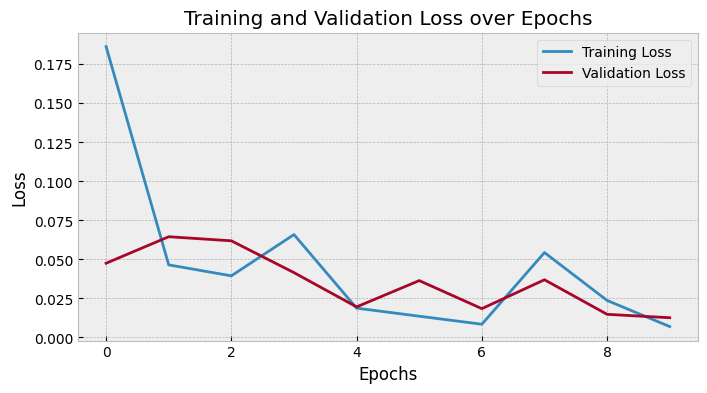

In [68]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA_1.history['loss'], label='Training Loss')
plt.plot(history_modelA_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

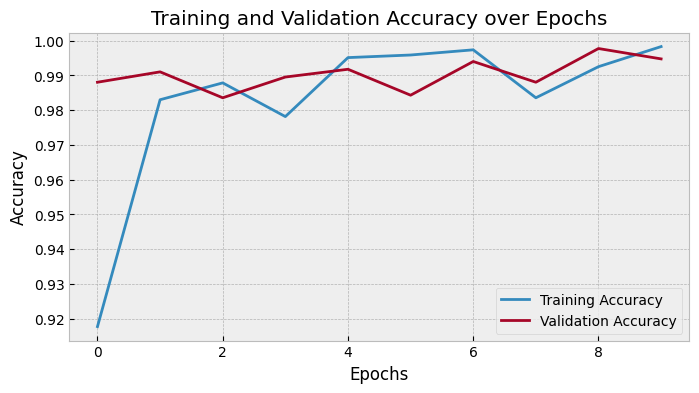

In [69]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [91]:
# Save the entire model
history_modelA_1.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/modelA_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step


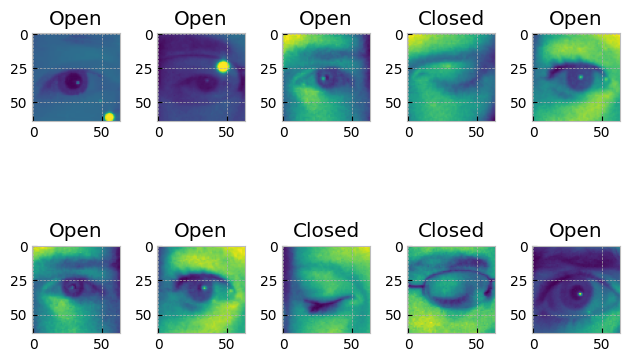

In [71]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelA_1.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 3s 33ms/step


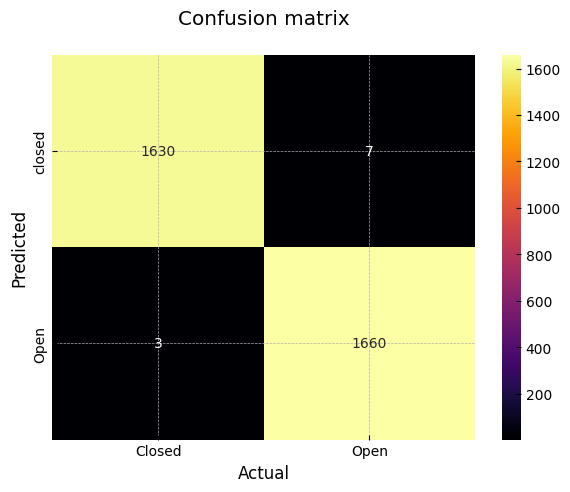

In [72]:
# Make predictions
preds2 = history_modelA_1.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

### 30 epochs with 64 batch size

In [80]:
# Define the path to save the model
model_checkpoint_path2 = os.path.join(path, 'bestmodel_modelA_2.h5')

In [81]:
callback_base_2 = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path2,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [82]:
# Train the model
history_modelA_2 = modelA.fit(x_train, y_train_encoded, validation_split=0.2, epochs=30, batch_size=64, callbacks=callback_base_2)

Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.8905
Epoch 1: val_loss improved from inf to 0.06129, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 29s 335ms/step - loss: 0.2472 - accuracy: 0.8905 - val_loss: 0.0613 - val_accuracy: 0.9806
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9778
Epoch 2: val_loss improved from 0.06129 to 0.04997, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA_2.h5
84/84 [==============================] - 31s 366ms/step - loss: 0.0617 - accuracy: 0.9778 - val_loss: 0.0500 - val_accuracy: 0.9821
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9894
Epoch 3: val_loss improved from 0.04997 to 0.02624, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA_2.h5
84/84 [==============================] - 32s 376ms/step - loss: 0.0283 - accuracy: 0.9894 - val_loss: 0.0262 - val_accuracy: 0.9925
Epoch 4/30
84/84 [==============================] - ETA: 0s - loss: 0.0176 - accurac

In [83]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA_2 = history_modelA_2.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA_2[0])
print('Test accuracy:', test_loss_accuracy_modelA_2[1])

104/104 [==============================] - 4s 36ms/step - loss: 0.0047 - accuracy: 0.9985
Test loss: 0.0046537090092897415
Test accuracy: 0.9984848499298096


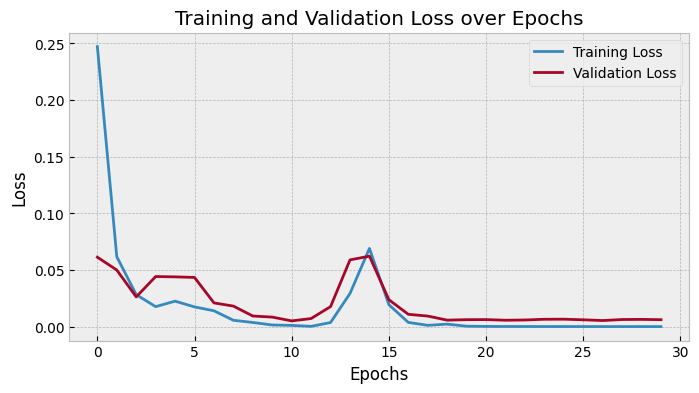

In [84]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA_2.history['loss'], label='Training Loss')
plt.plot(history_modelA_2.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

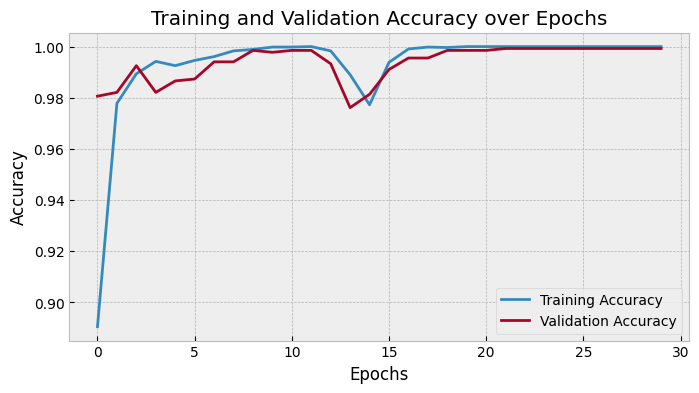

In [85]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA_2.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [87]:
# Save the entire model
history_modelA_2.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/modelA_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 27ms/step


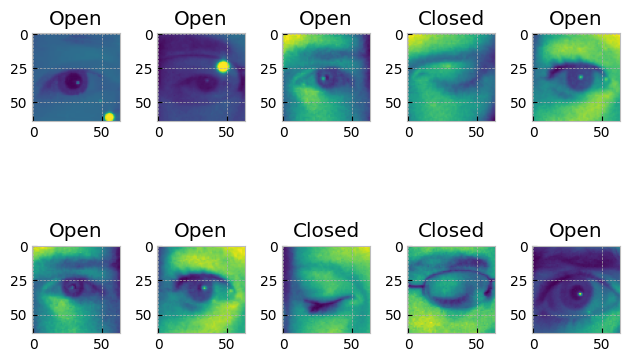

In [88]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelA_2.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 3s 31ms/step


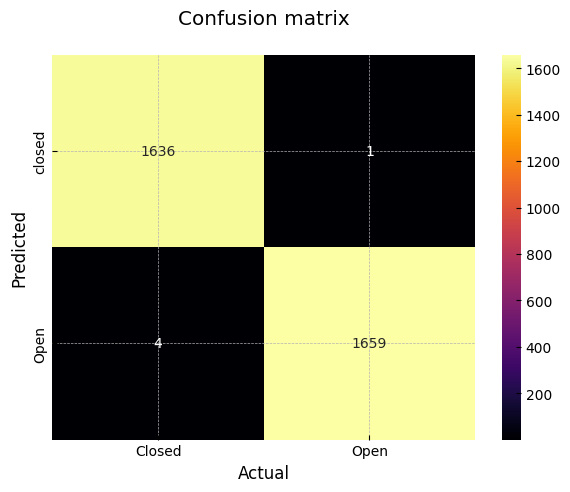

In [89]:
# Make predictions
preds2 = history_modelA_2.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

### 10 epochs with 64 batch size

In [98]:
# Define the path to save the model
model_checkpoint_path3 = os.path.join(path, 'bestmodel_modelA_3.h5')

In [99]:
callback_base_3 = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path3,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [100]:
# Train the model
history_modelA_3 = modelA.fit(x_train, y_train_encoded, validation_split=0.2, epochs=10, batch_size=64, callbacks=callback_base_3)

Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8916
Epoch 1: val_loss improved from inf to 0.09821, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA_3.h5
84/84 [==============================] - 30s 353ms/step - loss: 0.2712 - accuracy: 0.8916 - val_loss: 0.0982 - val_accuracy: 0.9769
Epoch 2/10
84/84 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9819
Epoch 2: val_loss improved from 0.09821 to 0.04884, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_modelA_3.h5
84/84 [==============================] - 33s 398ms/step - loss: 0.0495 - accuracy: 0.9819 - val_loss: 0.0488 - val_accuracy: 0.9828
Epoch 3/10
84/84 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9897
Epoch 3: val_loss improved from 0.04884 to 0.04632, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_

In [107]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA_3 = history_modelA_3.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA_3[0])
print('Test accuracy:', test_loss_accuracy_modelA_3[1])

104/104 [==============================] - 3s 32ms/step - loss: 0.1808 - accuracy: 0.9224
Test loss: 0.18083037436008453
Test accuracy: 0.9224242568016052


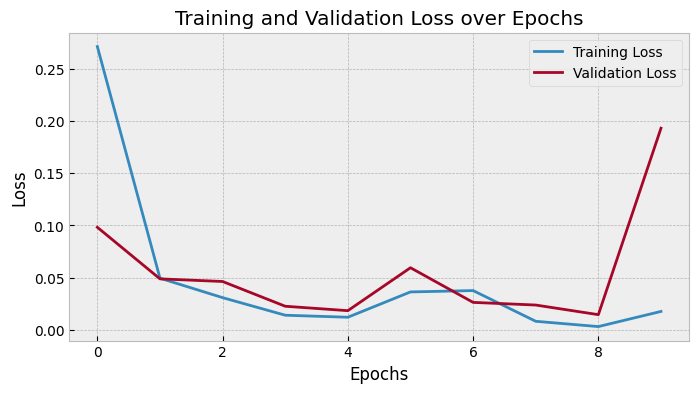

In [108]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA_3.history['loss'], label='Training Loss')
plt.plot(history_modelA_3.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

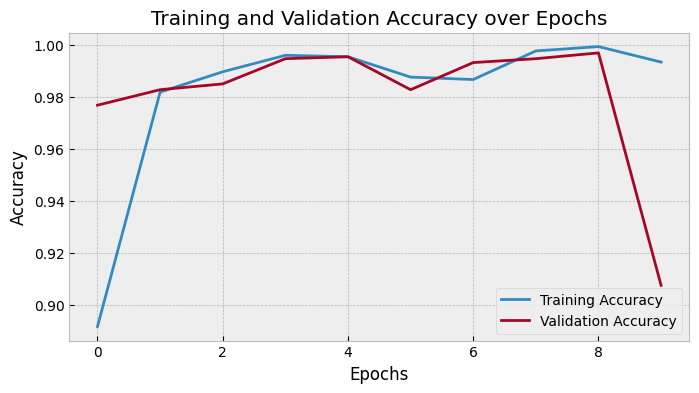

In [109]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA_3.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [110]:
# Save the entire model
history_modelA_3.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/modelA_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step


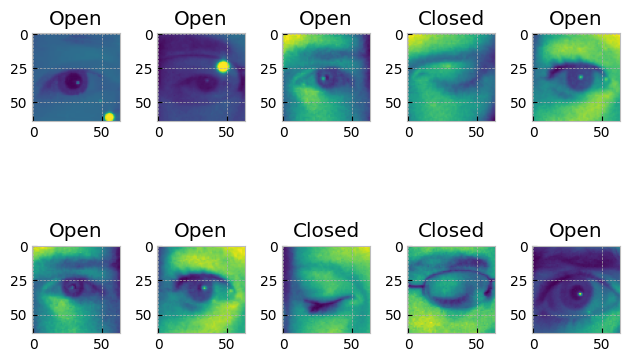

In [111]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelA_3.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 3s 32ms/step


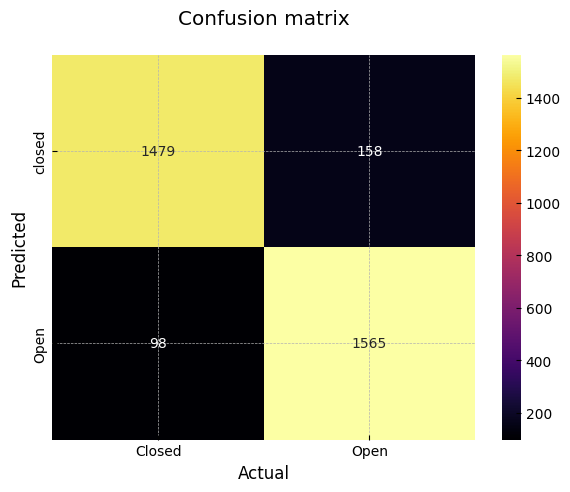

In [112]:
# Make predictions
preds2 = history_modelA_3.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

## 2. ModelB - Previous model with batch normalization, maxpooling and dropouts

In [47]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# Define convolutional layers
conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
max_pool1 = MaxPooling2D(strides=2)(batch_norm1)
dropout1 = Dropout(0.3)(max_pool1)

conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation='relu')(dropout1)
batch_norm2 = BatchNormalization()(conv2)
max_pool2 = MaxPooling2D(strides=2)(batch_norm2)
dropout2 = Dropout(0.3)(max_pool2)

# Define flatten layer
flatten = Flatten()(dropout2)

# Define dense layers
dense1 = Dense(units=128, use_bias=False, activation='relu')(flatten)
batch_norm3 = BatchNormalization()(dense1)

dense2 = Dense(units=84, use_bias=False, activation='relu')(dense1)
batch_norm4 = BatchNormalization()(dense2)
dropout3 = Dropout(0.3)(batch_norm4)

# Define output layer
output_layer = Dense(units=1, activation='sigmoid')(dropout3)

# Construct the model
modelB = Model(inputs=input_layer, outputs=output_layer)

In [114]:
# Explore model summary
modelB.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496 

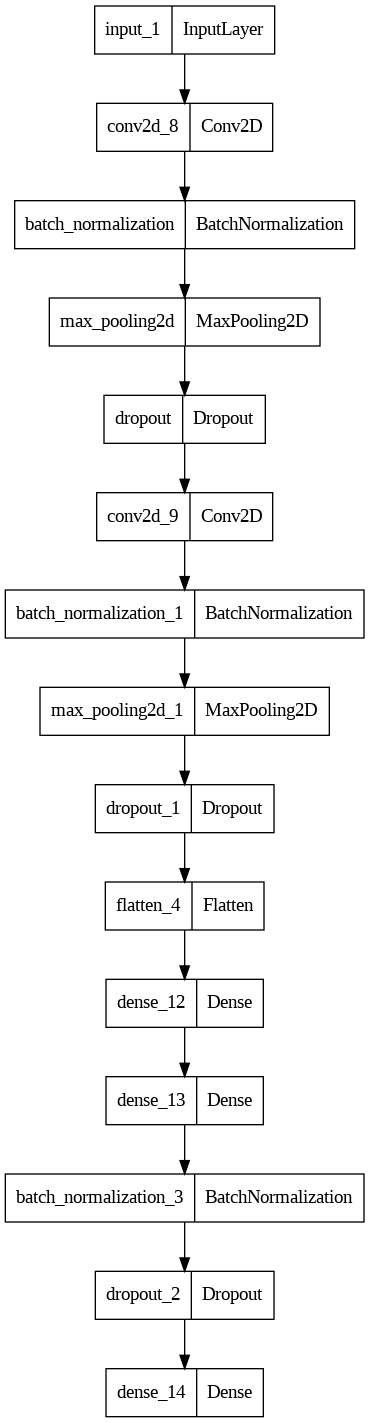

In [115]:
# Plot model
plot_model(modelB)

In [48]:
# Compiling the model
modelB.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
# Define the path to save the model
path = '../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest'

# Ensure the directory exists
os.makedirs(path, exist_ok=True)

### 30 epochs with 32 batch size

In [119]:
# Define the path to save the model
model_checkpoint_pathB_1 = os.path.join(path, 'bestModel_B_1.h5')

In [121]:
callback_B_1 = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_pathB_1,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [122]:
# Train the model
history2 = modelB.fit(x_train, y_train_encoded, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_B_1)

Epoch 1/30
167/168 [============================>.] - ETA: 0s - loss: 0.1181 - accuracy: 0.9566
Epoch 1: val_loss improved from inf to 1.81970, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_B_1.h5
168/168 [==============================] - 11s 58ms/step - loss: 0.1183 - accuracy: 0.9563 - val_loss: 1.8197 - val_accuracy: 0.5037
Epoch 2/30
  2/168 [..............................] - ETA: 8s - loss: 0.0150 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/168 [============================>.] - ETA: 0s - loss: 0.0487 - accuracy: 0.9845
Epoch 2: val_loss improved from 1.81970 to 1.71039, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_B_1.h5
168/168 [==============================] - 10s 62ms/step - loss: 0.0486 - accuracy: 0.9845 - val_loss: 1.7104 - val_accuracy: 0.5060
Epoch 3/30
167/168 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9929
Epoch 3: val_loss improved from 1.71039 to 0.33813, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_B_1.h5
168/168 [==============================] - 10s 59ms/step - loss: 0.0215 - accuracy: 0.9927 - val_loss: 0.3381 - val_accuracy: 0.8440
Epoch 4/30
167/168 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9970
Epoch 4: val_loss improved from 0.33813 to 0.01700, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/L

In [123]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_2B = history2.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_2B[0])
print('Test accuracy:', test_loss_accuracy_2B[1])

104/104 [==============================] - 1s 13ms/step - loss: 0.0040 - accuracy: 0.9985
Test loss: 0.003985030110925436
Test accuracy: 0.9984848499298096


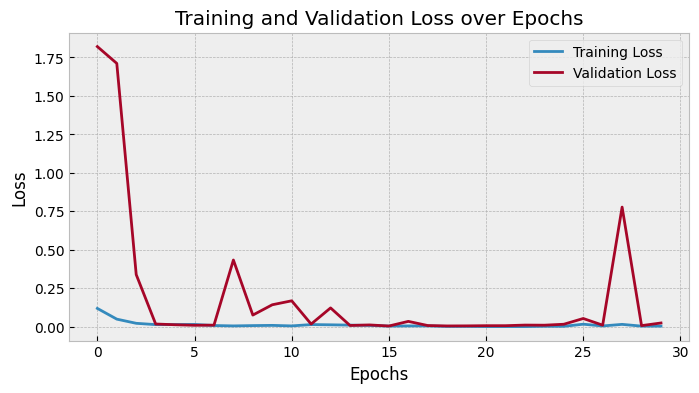

In [124]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

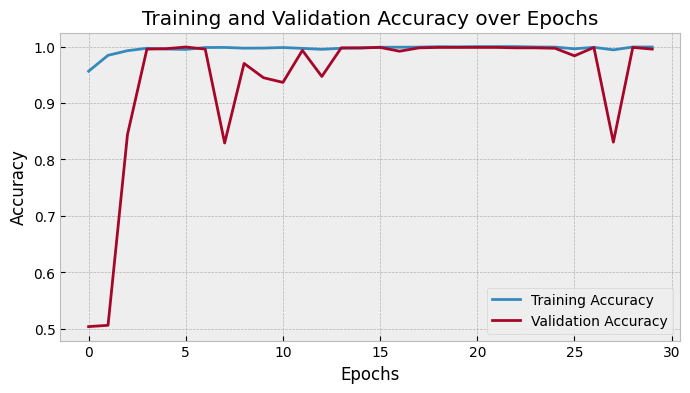

In [125]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [126]:
# Save the entire model
history2.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/v_2/modelB.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


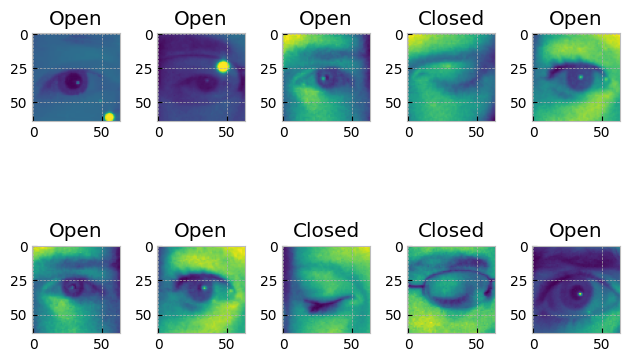

In [127]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history2.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 1s 14ms/step


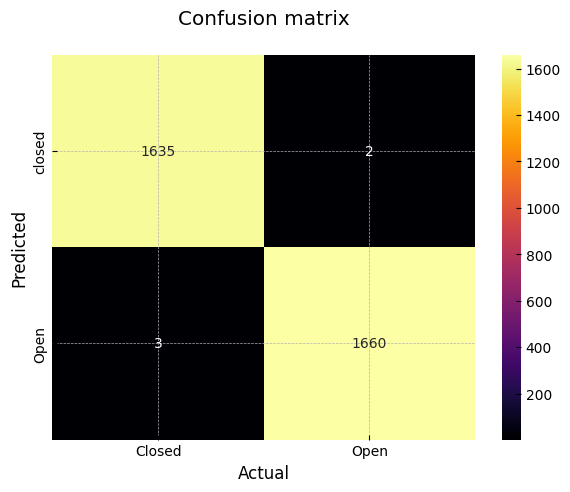

In [128]:
# Make predictions
preds2 = history2.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

### 30 epochs with 64 batch size

In [155]:
# Define the path to save the model
model_checkpoint_pathB_2 = os.path.join(path, 'bestModel_B_2.h5')

In [156]:
callback_B_2m = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_pathB_2,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [157]:
# Train the model
history_modelB_2 = modelB.fit(x_train, y_train_encoded, validation_split=0.2, epochs=30, batch_size=64, callbacks=callback_B_2m)

Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9563
Epoch 1: val_loss improved from inf to 0.81218, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_B_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 10s 106ms/step - loss: 0.1217 - accuracy: 0.9563 - val_loss: 0.8122 - val_accuracy: 0.5037
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9896
Epoch 2: val_loss did not improve from 0.81218
84/84 [==============================] - 8s 97ms/step - loss: 0.0362 - accuracy: 0.9896 - val_loss: 0.9915 - val_accuracy: 0.5306
Epoch 3/30
84/84 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9933
Epoch 3: val_loss did not improve from 0.81218
84/84 [==============================] - 8s 95ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 1.6398 - val_accuracy: 0.5037
Epoch 4/30
84/84 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9978
Epoch 4: val_loss did not improve from 0.81218
84/84 [==============================] - 8s 95ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 1.7444 - val_accuracy: 0.5940
Epoch 5/30
84/84 [==============================] - ETA

In [158]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_2B_2 = history_modelB_2.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_2B_2[0])
print('Test accuracy:', test_loss_accuracy_2B_2[1])

104/104 [==============================] - 1s 12ms/step - loss: 0.0404 - accuracy: 0.9864
Test loss: 0.04044909402728081
Test accuracy: 0.9863636493682861


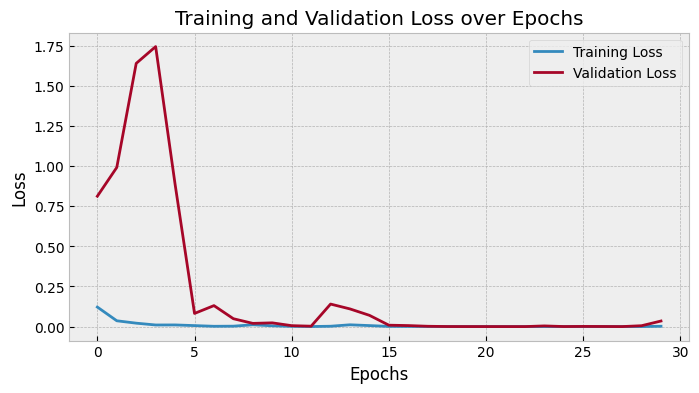

In [159]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelB_2.history['loss'], label='Training Loss')
plt.plot(history_modelB_2.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

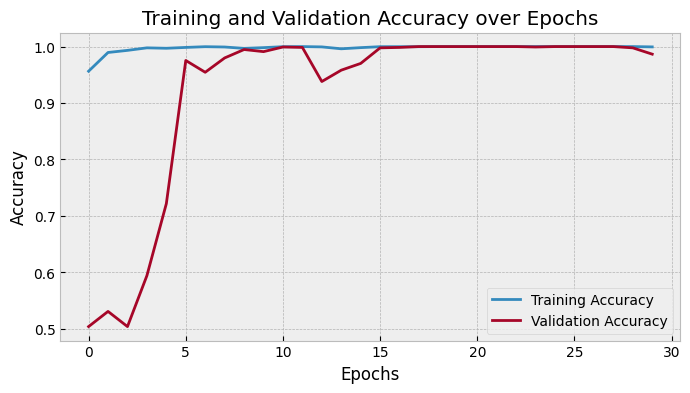

In [160]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelB_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelB_2.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [161]:
# Save the entire model
history_modelB_2.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/v_2/modelB_2.h5')

1/1 [==============================] - 0s 17ms/step


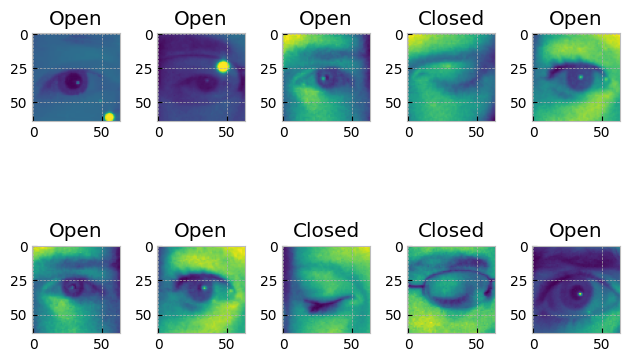

In [162]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelB_2.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 1s 12ms/step


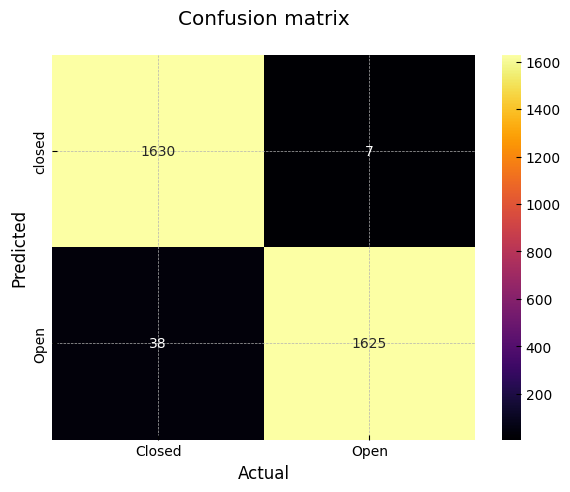

In [163]:
# Make predictions
preds2 = history_modelB_2.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

## 3. ModelC - Previous model with increased droupout value

In [58]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# Define convolutional layers
conv1 = Conv2D(filters=32, kernel_size=3, strides=1, activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
max_pool1 = MaxPooling2D(strides=2)(batch_norm1)
dropout1 = Dropout(0.5)(max_pool1)

conv2 = Conv2D(filters=64, kernel_size=3, strides=1, activation='relu')(dropout1)
batch_norm2 = BatchNormalization()(conv2)
max_pool2 = MaxPooling2D(strides=2)(batch_norm2)
dropout2 = Dropout(0.5)(max_pool2)

# Define flatten layer
flatten = Flatten()(dropout2)

# Define dense layers
dense1 = Dense(units=128, use_bias=False, activation='relu')(flatten)
batch_norm3 = BatchNormalization()(dense1)

dense2 = Dense(units=84, use_bias=False, activation='relu')(dense1)
batch_norm4 = BatchNormalization()(dense2)
dropout3 = Dropout(0.5)(batch_norm4)

# Define output layer
output_layer = Dense(units=1, activation='sigmoid')(dropout3)

# Construct the model
modelC = Model(inputs=input_layer, outputs=output_layer)

In [142]:
# Explore model summary
modelC.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_8 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        1849

In [59]:
# Compiling the model
modelC.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [144]:
# Define the path to save the model
model_checkpoint_pathC_1 = os.path.join(path, 'bestModel_C_1.h5')

In [145]:
callback_C_1 = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_pathC_1,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [146]:
# Train the model
history_modelC_1 = modelC.fit(x_train, y_train_encoded, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_C_1)

Epoch 1/30
167/168 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9420
Epoch 1: val_loss improved from inf to 1.86460, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_C_1.h5
168/168 [==============================] - 10s 55ms/step - loss: 0.1572 - accuracy: 0.9422 - val_loss: 1.8646 - val_accuracy: 0.5037
Epoch 2/30
  2/168 [..............................] - ETA: 8s - loss: 0.0977 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/168 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9828
Epoch 2: val_loss did not improve from 1.86460
168/168 [==============================] - 9s 55ms/step - loss: 0.0556 - accuracy: 0.9828 - val_loss: 2.0238 - val_accuracy: 0.5037
Epoch 3/30
167/168 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9893
Epoch 3: val_loss improved from 1.86460 to 0.33152, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_C_1.h5
168/168 [==============================] - 10s 60ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.3315 - val_accuracy: 0.8582
Epoch 4/30
167/168 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9931
Epoch 4: val_loss improved from 0.33152 to 0.04720, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_C_1.h5
168/168 [==============================] - 11s 64ms/step - loss: 0.0269 - accuracy: 0.9929 

In [147]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_2C = history2.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_2C[0])
print('Test accuracy:', test_loss_accuracy_2C[1])

104/104 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9994
Test loss: 0.0017175344983115792
Test accuracy: 0.9993939399719238


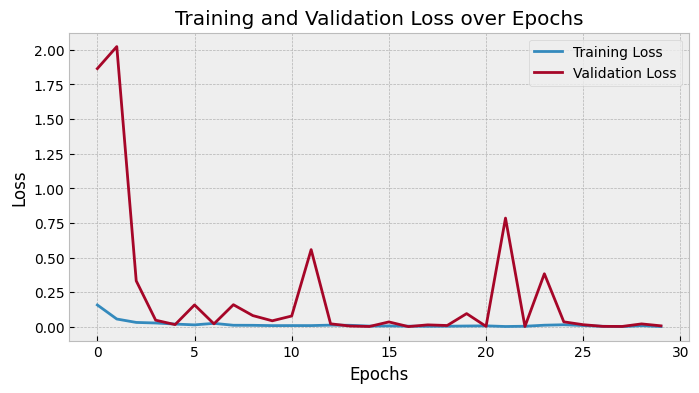

In [148]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelC_1.history['loss'], label='Training Loss')
plt.plot(history_modelC_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

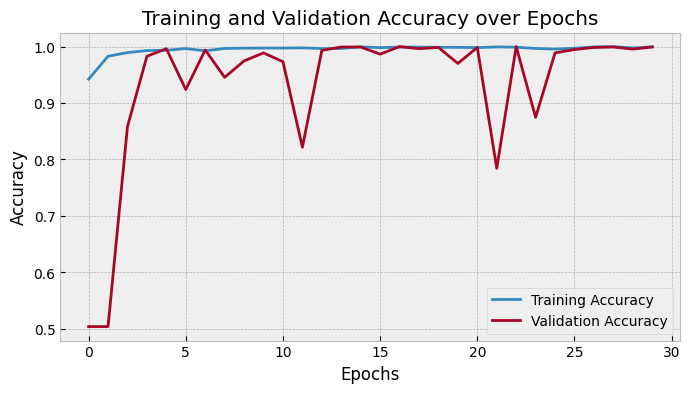

In [149]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelC_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelC_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [150]:
# Save the entire model
history_modelC_1.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/v_2/modelC_!.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step


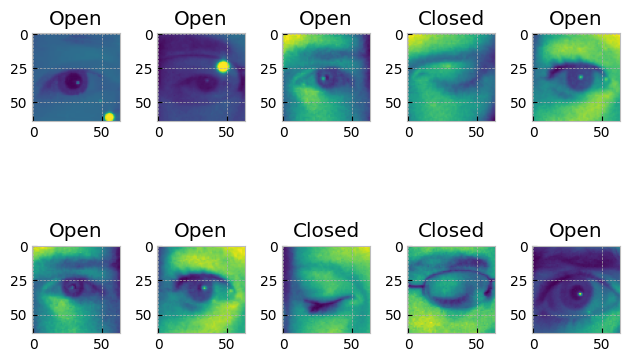

In [151]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelC_1.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 1s 13ms/step


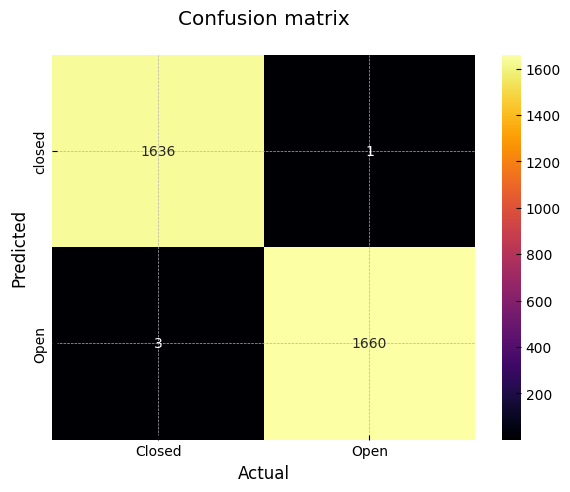

In [152]:
# Make predictions
preds2 = history_modelC_1.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

## ModelA with data augmentation

In [37]:
# Define the path to save the model
model_checkpoint_path_modelA_aug = os.path.join(path, 'bestmodel_A_aug_1.h5')

In [38]:
callback_base_aug = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelA_aug,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [39]:
# Split the training data into training and validation sets
x_train_1, x_val, y_train_encoded_1, y_val_encoded = train_test_split(x_train, y_train_encoded, test_size=0.2, random_state=42)

In [40]:
# Train the model
history_modelA_aug1 = modelA.fit(
    train_generator.flow(x_train_1, y_train_encoded_1, batch_size=32),
    steps_per_epoch=len(x_train_1) / 32,
    epochs=30,
    validation_data=(x_val, y_val_encoded),
    callbacks=callback_base_aug
)

Epoch 1/30
168/167 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.7860
Epoch 1: val_loss improved from inf to 0.27178, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_A_aug_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/167 [==============================] - 52s 300ms/step - loss: 0.4530 - accuracy: 0.7860 - val_loss: 0.2718 - val_accuracy: 0.9112
Epoch 2/30
168/167 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8705
Epoch 2: val_loss improved from 0.27178 to 0.16204, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_A_aug_1.h5
167/167 [==============================] - 51s 304ms/step - loss: 0.2954 - accuracy: 0.8705 - val_loss: 0.1620 - val_accuracy: 0.9493
Epoch 3/30
168/167 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8836
Epoch 3: val_loss improved from 0.16204 to 0.15952, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestmodel_A_aug_1.h5
167/167 [==============================] - 51s 302ms/step - loss: 0.2681 - accuracy: 0.8836 - val_loss: 0.1595 - val_accuracy: 0.9552
Epoch 4/30
168/167 [==============================] - ETA: 0s - loss: 0.2430

In [41]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA_aug = history_modelA_aug1.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA_aug[0])
print('Test accuracy:', test_loss_accuracy_modelA_aug[1])

104/104 [==============================] - 4s 41ms/step - loss: 0.0236 - accuracy: 0.9918
Test loss: 0.023607078939676285
Test accuracy: 0.9918181896209717


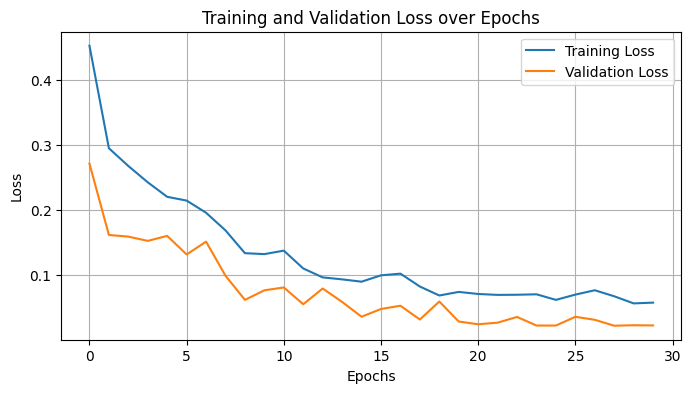

In [42]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA_aug1.history['loss'], label='Training Loss')
plt.plot(history_modelA_aug1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

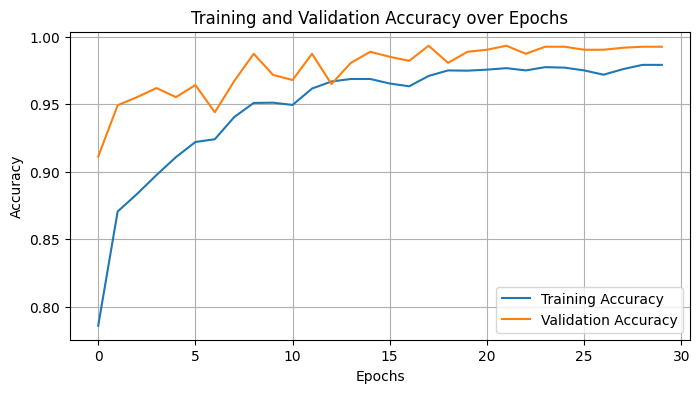

In [43]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA_aug1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA_aug1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [44]:
# Save the entire model
history_modelA_aug1.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/v_2/base_model_aug.h5')

1/1 [==============================] - 0s 35ms/step


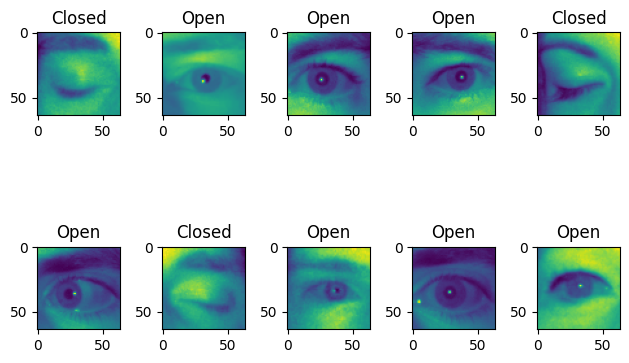

In [45]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelA_aug1.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 5s 45ms/step


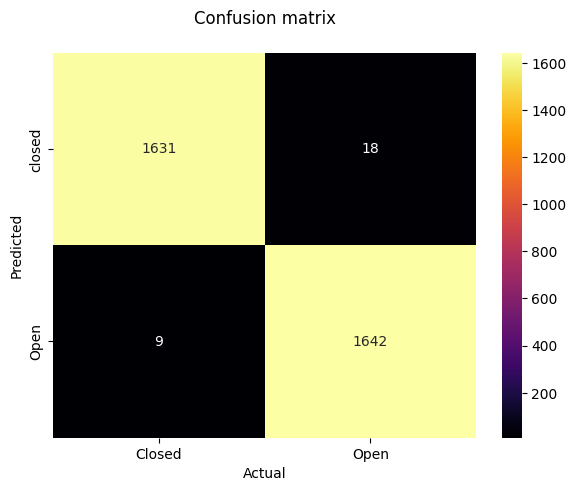

In [46]:
# Make predictions
preds2 = history_modelA_aug1.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

## ModelB with data augmentation

In [49]:
# Define the path to save the model
model_checkpoint_modelB_aug = os.path.join(path, 'bestModel_model2_aug.h5')

In [50]:
callback_modelB_aug = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_modelB_aug,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [51]:
# Train the model
history_modelB_aug = modelB.fit(
    train_generator.flow(x_train_1, y_train_encoded_1, batch_size=32),
    steps_per_epoch=len(x_train_1) / 32,
    epochs=30,
    validation_data=(x_val, y_val_encoded),
    callbacks=callback_modelB_aug
)

Epoch 1/30
168/167 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8502
Epoch 1: val_loss improved from inf to 0.63460, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestModel_model2_aug.h5
167/167 [==============================] - 15s 78ms/step - loss: 0.3513 - accuracy: 0.8502 - val_loss: 0.6346 - val_accuracy: 0.5418


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
168/167 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8853
Epoch 2: val_loss did not improve from 0.63460
167/167 [==============================] - 13s 76ms/step - loss: 0.2829 - accuracy: 0.8853 - val_loss: 0.8374 - val_accuracy: 0.6075
Epoch 3/30
168/167 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9030
Epoch 3: val_loss improved from 0.63460 to 0.42893, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestModel_model2_aug.h5
167/167 [==============================] - 13s 79ms/step - loss: 0.2390 - accuracy: 0.9030 - val_loss: 0.4289 - val_accuracy: 0.7791
Epoch 4/30
168/167 [==============================] - ETA: 0s - loss: 0.2213 - accuracy: 0.9052
Epoch 4: val_loss improved from 0.42893 to 0.20208, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/bestModel_model2_aug.h5
167/167 [==============================] - 14s 81ms/step - loss

In [52]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelB_aug = history_modelB_aug.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelB_aug[0])
print('Test accuracy:', test_loss_accuracy_modelB_aug[1])

104/104 [==============================] - 2s 17ms/step - loss: 0.0197 - accuracy: 0.9942
Test loss: 0.019711865112185478
Test accuracy: 0.9942424297332764


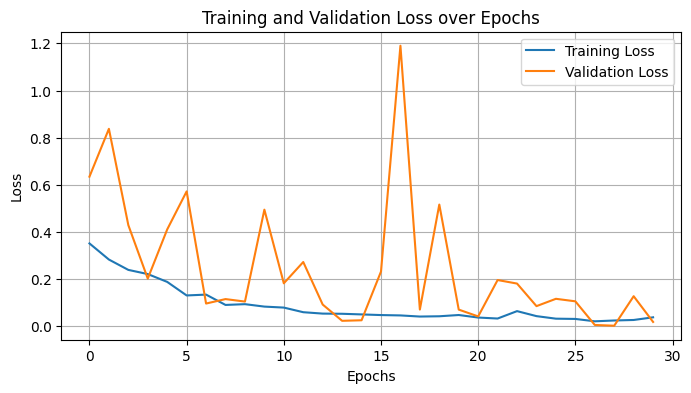

In [53]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelB_aug.history['loss'], label='Training Loss')
plt.plot(history_modelB_aug.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

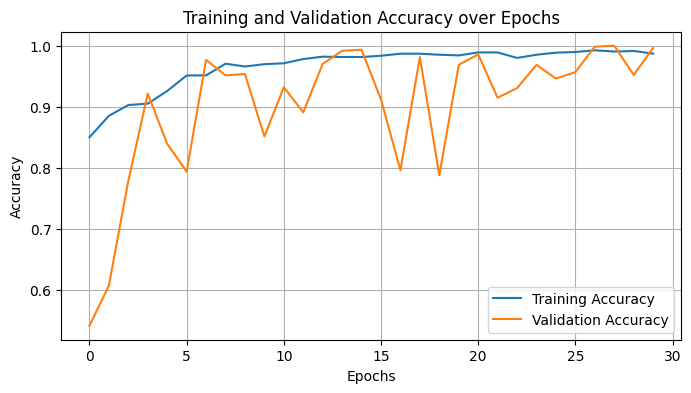

In [54]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelB_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelB_aug.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [55]:
# Save the entire model
history_modelB_aug.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/v_2/model2_aug.h5')

1/1 [==============================] - 0s 24ms/step


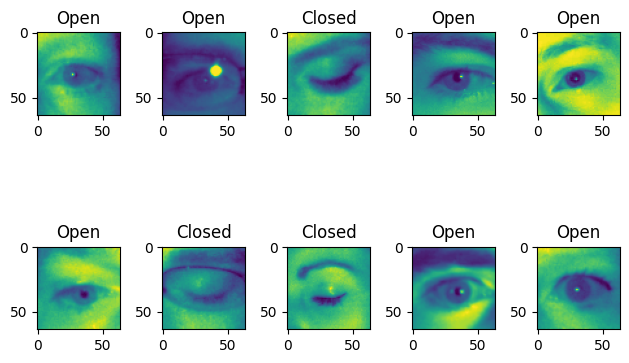

In [56]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[10:20]):

    # Make prediction
    result = history_modelB_aug.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 2s 17ms/step


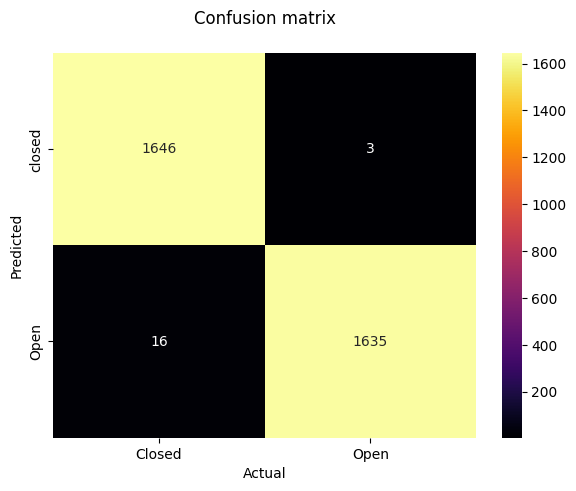

In [57]:
# Make predictions
preds2 = history_modelB_aug.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

## ModelC with data augmentation

In [60]:
# Define the path to save the model
model_checkpoint_path_modelC = os.path.join(path, 'besemodel_modelc_aug.h5')

In [61]:
callback_base_modelC = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelC,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [62]:
# Split the training data into training and validation sets
x_train_1, x_val, y_train_encoded_1, y_val_encoded = train_test_split(x_train, y_train_encoded, test_size=0.2, random_state=42)

In [63]:
# Train the model
history_modelC_aug= modelC.fit(
    train_generator.flow(x_train_1, y_train_encoded_1, batch_size=32),
    steps_per_epoch=len(x_train_1) / 32,
    epochs=30,
    validation_data=(x_val, y_val_encoded),
    callbacks=callback_base_modelC
)

Epoch 1/30
168/167 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8252
Epoch 1: val_loss improved from inf to 0.99046, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/besemodel_modelc_aug.h5
167/167 [==============================] - 15s 82ms/step - loss: 0.4065 - accuracy: 0.8252 - val_loss: 0.9905 - val_accuracy: 0.5082


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
168/167 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8789
Epoch 2: val_loss improved from 0.99046 to 0.86720, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/besemodel_modelc_aug.h5
167/167 [==============================] - 14s 81ms/step - loss: 0.2875 - accuracy: 0.8789 - val_loss: 0.8672 - val_accuracy: 0.5104
Epoch 3/30
168/167 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.8924
Epoch 3: val_loss improved from 0.86720 to 0.41335, saving model to ../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest1/besemodel_modelc_aug.h5
167/167 [==============================] - 13s 80ms/step - loss: 0.2603 - accuracy: 0.8924 - val_loss: 0.4133 - val_accuracy: 0.8112
Epoch 4/30
168/167 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.8965
Epoch 4: val_loss did not improve from 0.41335
167/167 [==============================] - 13s 76ms/step - loss

In [65]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_base_aug90 = history_modelC_aug.model.evaluate(x_test, y_test_encoded, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_base_aug90[0])
print('Test accuracy:', test_loss_accuracy_base_aug90[1])

104/104 [==============================] - 2s 18ms/step - loss: 0.0288 - accuracy: 0.9867
Test loss: 0.02884237840771675
Test accuracy: 0.9866666793823242


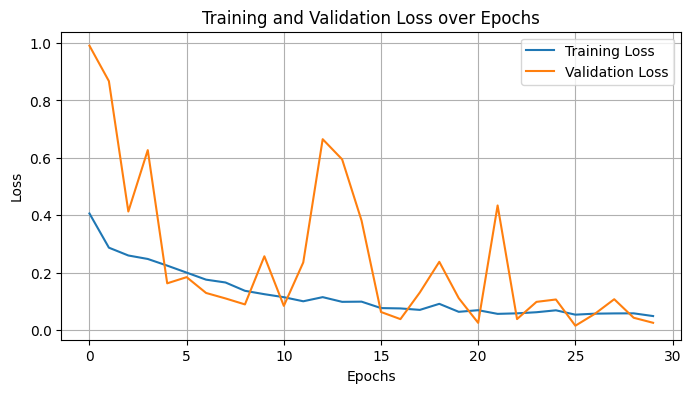

In [66]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelC_aug.history['loss'], label='Training Loss')
plt.plot(history_modelC_aug.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

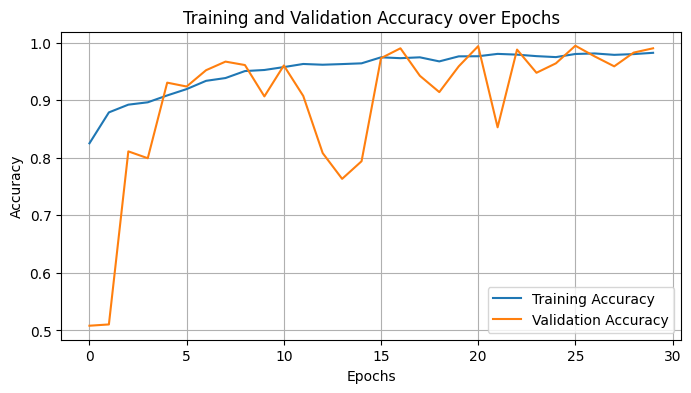

In [67]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelC_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelC_aug.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [68]:
# Save the entire model
history_modelC_aug.model.save('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/v_2/modelC_aug.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step


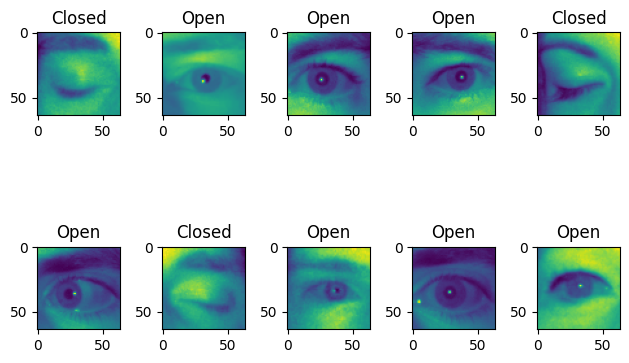

In [69]:
# Show the predictions

# Iterate over the 10 samples in x_test
for idx, i in enumerate(x_test[:10]):

    # Make prediction
    result = history_modelC_aug.model.predict(np.expand_dims(i,0))

    # Define subplot
    plt.subplot(2, 5, idx+1)

    # Plot the image
    plt.imshow(i)

    # Plot the predicted label
    if result > 0.5:
        plt.title('Open')
    else:
        plt.title('Closed')

    # Define axis
    plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

104/104 [==============================] - 2s 17ms/step


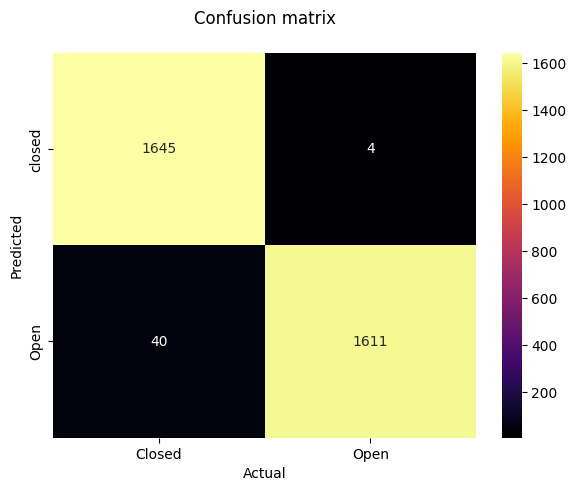

In [70]:
# Make predictions
preds2 = history_modelC_aug.model.predict(x_test)
preds2 = (preds2 >= 0.5).astype(np.int32)

# Define confusion matrix
cm = confusion_matrix(y_test_encoded, preds2)

# Construct confution matrix
plt.figure(figsize=(15, 5))

# Define df for confusion matrix
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])

# Create a subplot
plt.subplot(121)

# Plot the heatmap
sns.heatmap(df_cm, annot=True, fmt="d", cmap='inferno')

# Define axis
plt.axis('on')

# Add titles and labels
plt.title("Confusion matrix\n")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Show the plt
plt.show()

# Test

In [85]:
# Load image
me_img = '../content/drive/MyDrive/Research/test/open_me_2.jpeg'
me_img = cv2.imread(me_img)

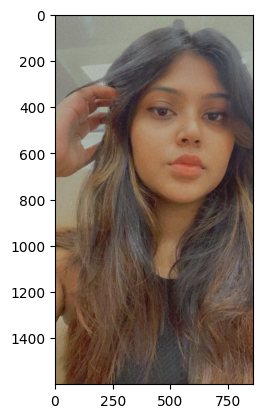

In [86]:
# Display image
plt.imshow(cv2.cvtColor(me_img,cv2.COLOR_BGR2RGB))

In [87]:
# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('../content/drive/MyDrive/Research/haarcascade_data/haarcascade_frontalface_default.xml')

In [88]:
# Load the Haar cascade classifier for eyes detection
eye_cascade = cv2.CascadeClassifier('../content/drive/MyDrive/Research/haarcascade_data/haarcascade_eye.xml')

In [89]:
# Detect eyes in the image using the eye cascade classifier
eyes = eye_cascade.detectMultiScale(me_img, scaleFactor=1.1, minNeighbors=4)

In [90]:
# Iterate over the list of rectangles
for x,y,w,h in eyes:
    # Draw squares over detected eyes
    cv2.rectangle(me_img,(x,y),(x+w ,y+h), (0, 255, 0), 2)

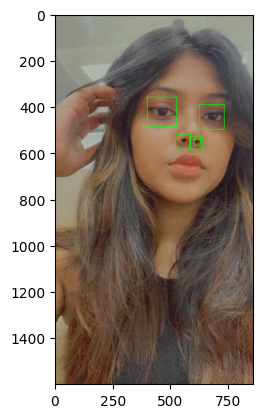

In [91]:
# Display image with detected rectangels
plt.imshow(cv2.cvtColor(me_img, cv2.COLOR_BGR2RGB))

In [92]:
# Iterate over the detected eye regions
for x,y,w,h in eyes:
     # Extract the region of interest from grayscale and color images
    roi_gray = me_img[y:y+h, x:x+w]
    roi_color = me_img[y:y+h, x:x+w]

    # Detect eyes within the ROI
    eyess = eye_cascade.detectMultiScale(roi_gray)

    # Check if eyes are detected
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for(ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey: ey+eh, ex:ex+ew]

eyes are not detected
eyes are not detected


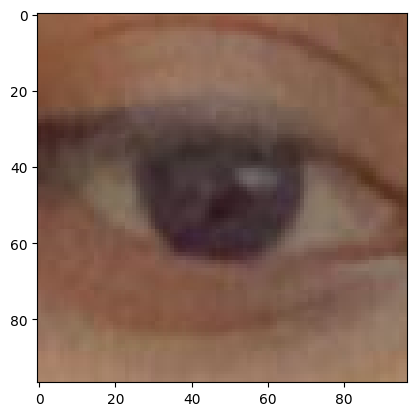

In [93]:
# Show detected eye
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [94]:
# Check the detected eye image shape
eyes_roi.shape

(97, 97, 3)

In [95]:
# Resize it into 64x64
final_image = cv2.resize(eyes_roi,(64,64))

In [96]:
# Confirm the image size
final_image.shape

(64, 64, 3)

In [97]:
# Convert the image into grayscale
grayscale_img = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

In [98]:
grayscale_img.shape

(64, 64)

In [101]:
best_model_v2 = load_model('../content/drive/MyDrive/Research/Saved_models/Drowsiness_detection/Latest/bestModel_C_1.h5')

In [103]:
# Define the image as an array
img_array = img_to_array(grayscale_img)

# Expand dimensions to create batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Normalize pixel values to [0, 1]
img_array /= 255.

# Make prediction
prediction = best_model_v2.predict(img_array)

# Convert prediction to label
label = "Closed" if prediction < 0.5 else "Open"
print("Prediction:", label)

1/1 [==============================] - 0s 121ms/step
Prediction: Open
